# Music Genre Classification with PCA
### A Machine Learning Project Predicting Music Styles through Dimensionality Reduction

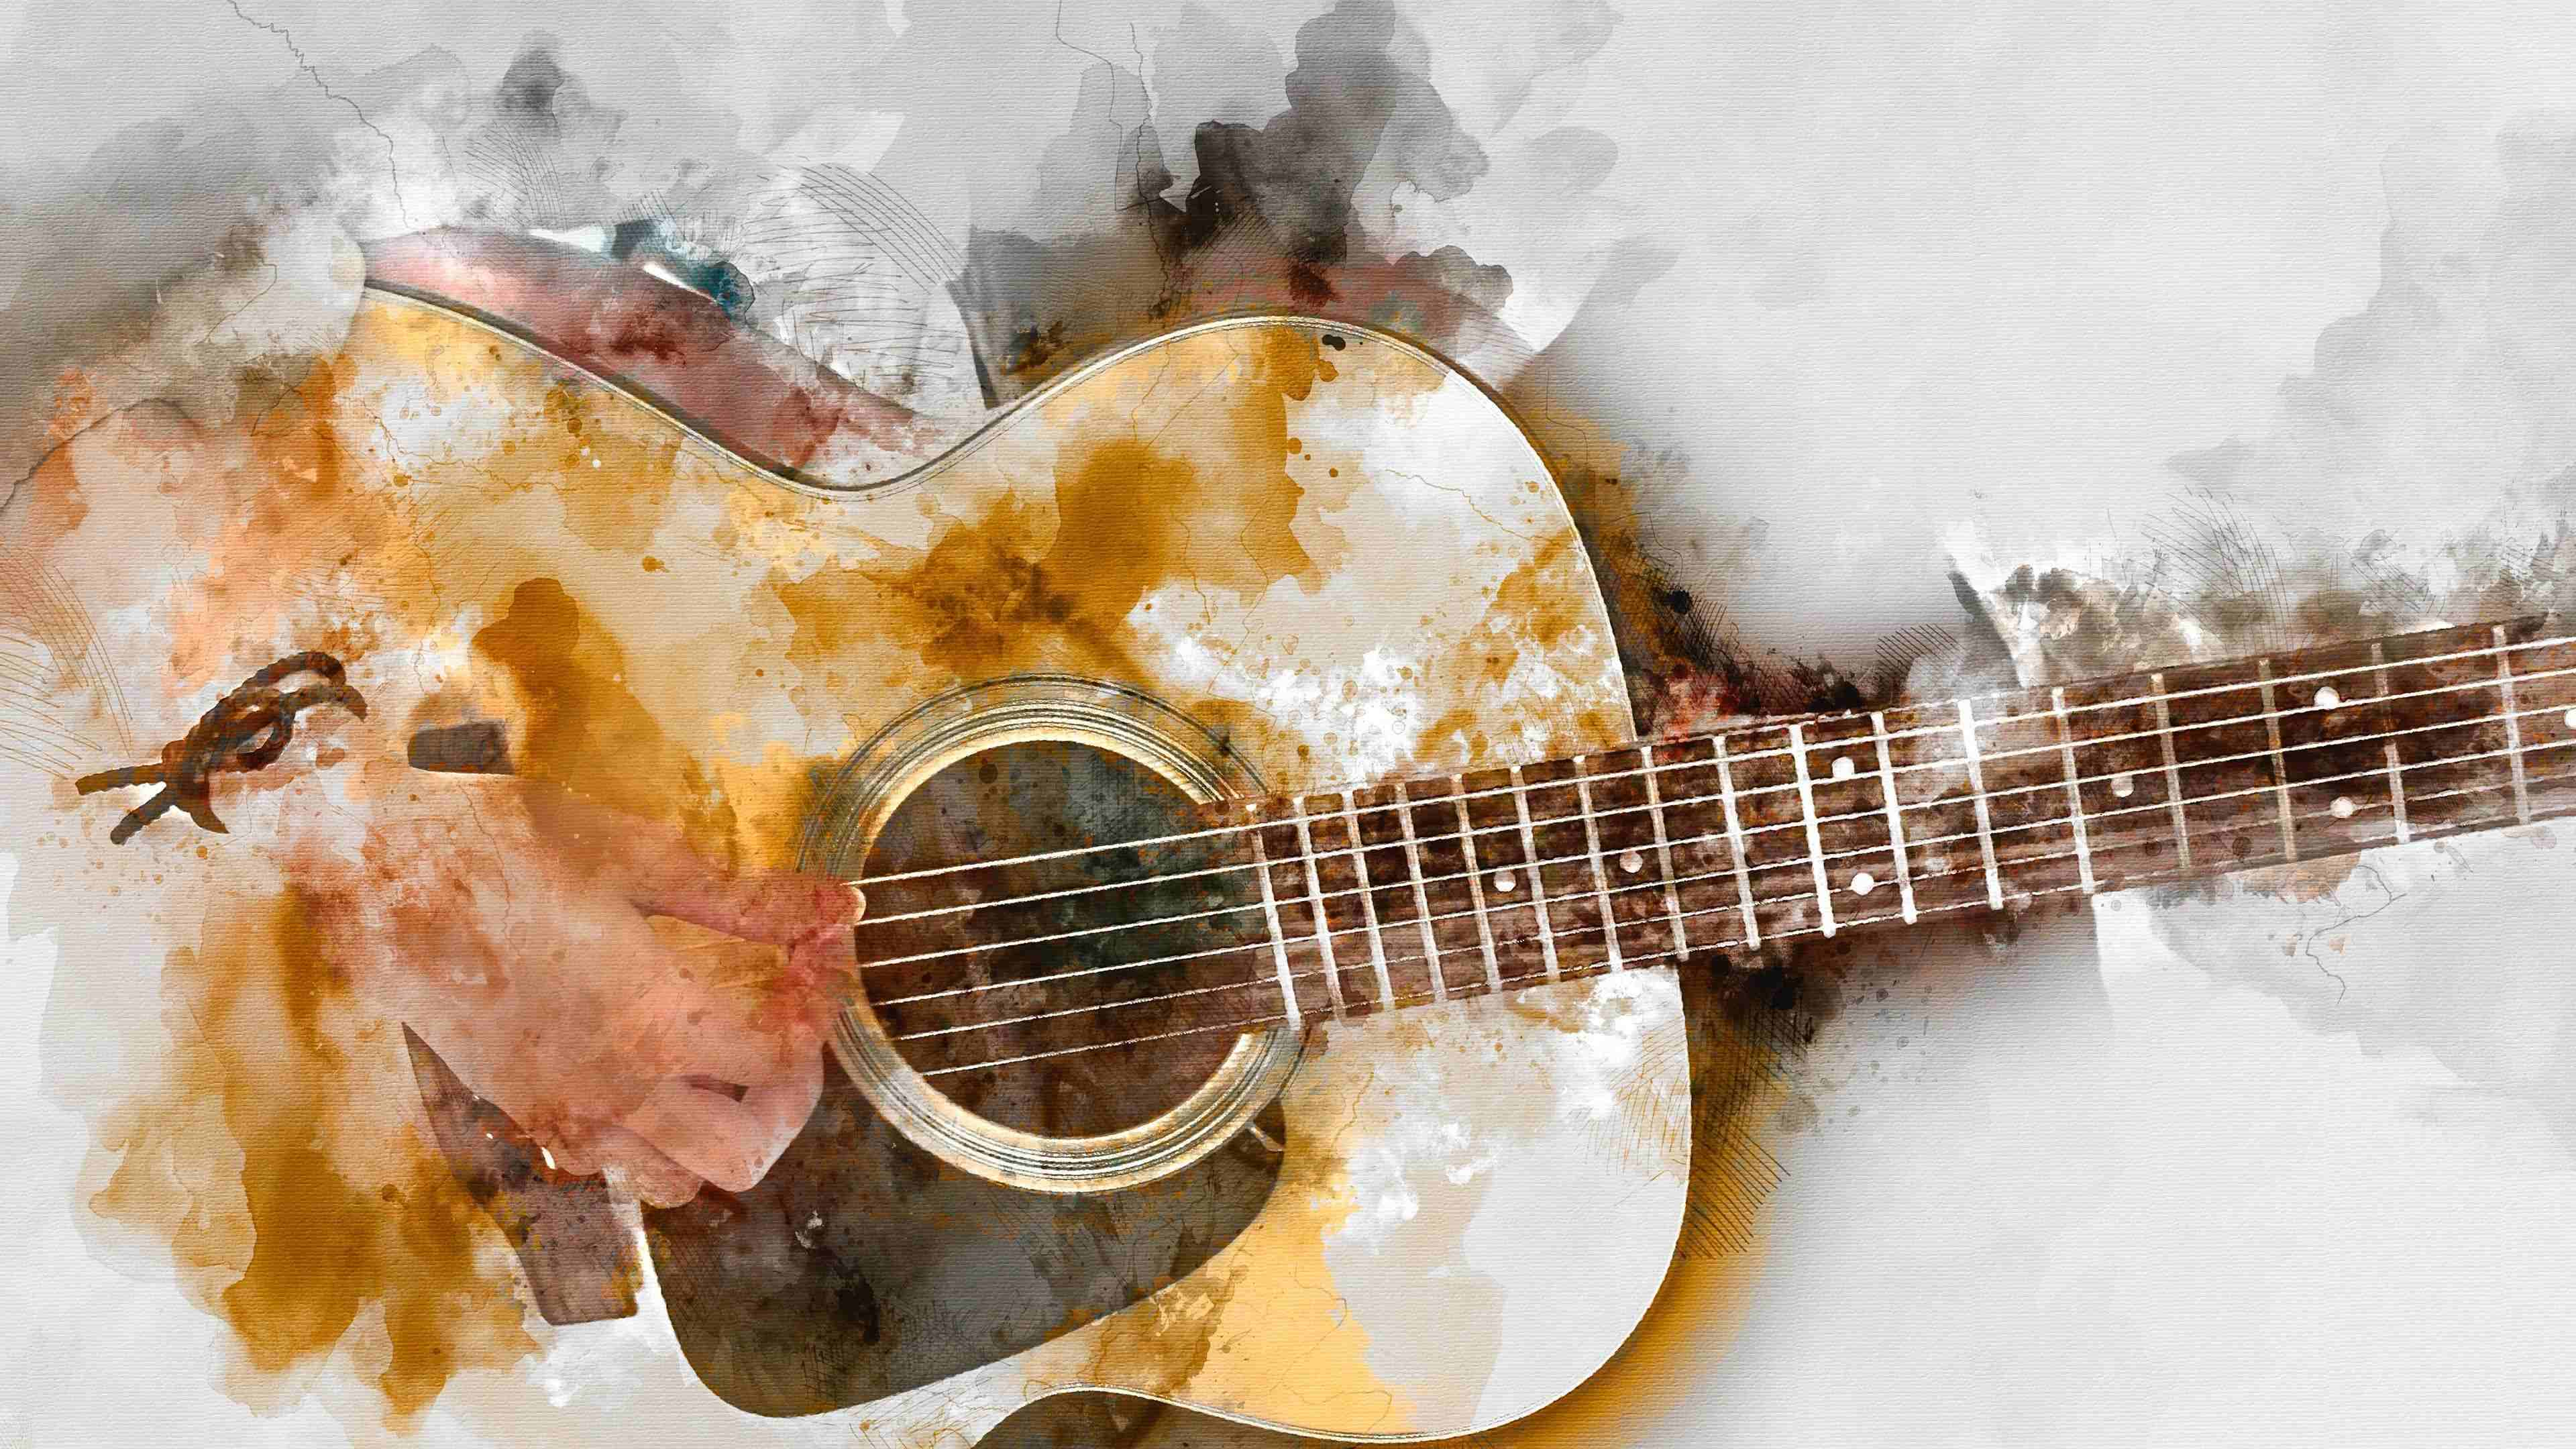

source: https://wallpaperaccess.com/musical-instruments#google_vignette

### Objective

In the era of digital streaming, there’s an increasing need to categorize and recommend music based on genres. By analyzing various musical features extracted from tracks, we can delve deeper into their defining patterns. <br> In this music genre classification project, we will work with a dataset containing various musical features extracted from tracks across different styles.

## Importing Required Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Reading Data

In [4]:
df = pd.read_csv("/kaggle/input/musicgenre/music_dataset_mod.csv")

In [5]:
df_genre = df.copy()

## Variable Description

| Variable                     | Data Type  | Description                                                                                        |
|------------------------------|------------|----------------------------------------------------------------------------------------------------|
| Tempo                        | numerical  | Beats per minute (BPM) of the track.                                                               |
| Dynamic Range                | numerical  | The range between the quietest and loudest parts of a track, typically measured in decibels (dB).  |
| Vocal Presence               | numerical  | The prominence of vocals in a track.                                                               |
| Percussion Strength          | numerical  | The intensity and presence of percussion instruments in a track, such as drums or cymbals.         |
| String Instrument Detection  | numerical  | The presence and prominence of string instruments like guitars, violins, or cellos in a track.     |
| Electronic Element Presence  | numerical  | The intensity and presence of electronic elements in a track, such as synthesizers.                |
| Rhythm Complexity            | numerical  | The complexity and variation in a track's rhythm patterns, reflecting the intricacy of its beat and timing. |
| Drums Influence              | numerical  | The drums contribution to the overall sound of a track, focusing on their impact rather than just presence. |
| Distorted Guitar             | numerical  | The extent to which distorted guitar sounds are used in a track.                                    |
| Metal Frequencies            | numerical  | The use of distorted guitar sounds, often associated with genres like rock or metal.               |
| Ambient Sound Influence      | numerical  | The use of ambient sounds in a track, which can add texture and atmospheric elements to the music. |
| Instrumental Overlaps        | numerical  | How different instruments interplay and overlap in a track, indicating the complexity of its instrumental arrangement. |
| Genre                        | categorical| The categorized genre of the track.                                                                |


## EDA

In [6]:
df_genre.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,Country
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,Classical
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,Rock
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,Hip-hop
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,Country


In [7]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tempo                        1000 non-null   float64
 1   Dynamics Range               1000 non-null   float64
 2   Vocal Presence               1000 non-null   float64
 3   Percussion Strength          1000 non-null   float64
 4   String Instrument Detection  1000 non-null   float64
 5   Electronic Element Presence  1000 non-null   float64
 6   Rhythm Complexity            1000 non-null   float64
 7   Drums Influence              1000 non-null   float64
 8   Distorted Guitar             1000 non-null   float64
 9   Metal Frequencies            1000 non-null   float64
 10  Ambient Sound Influence      1000 non-null   float64
 11  Instrumental Overlaps        1000 non-null   float64
 12  Genre                        890 non-null    object 
dtypes: float64(12), obj

Genre
Rock         0.19%
Jazz         0.19%
Country      0.18%
Hip-hop      0.17%
Classical    0.16%
NaN          0.11%
Name: proportion, dtype: object


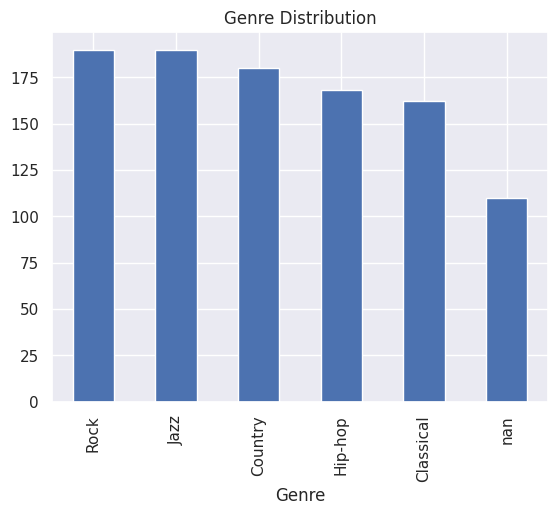

In [8]:
print(df_genre["Genre"].value_counts(normalize = True, dropna = False).map("{:.2f}%".format))

ax = df_genre["Genre"].value_counts(dropna = False).plot.bar()

plt.title("Genre Distribution");

Notes:
- All independent variables have no missing values.
- The target variable "Genre" has 110 null values.
- There are 5 genres: Rock, Jazz, Country, Hip-hop, Classical
- The distribution is balanced, with each genre representing 16-19% of the total. This balance ensures that our predictive model can equally learn about each genre.

## Correlation Analysis

In [9]:
# Drop all null values
df_genre_nonull = df_genre.dropna()

# Divide into features and the target
X = df_genre_nonull.drop("Genre", axis = 1)
y = df_genre_nonull["Genre"]

# Transform categorical variables into numerical ones
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Make a copy of df_genre_nonnull
df_genre_nonull_enc = df_genre_nonull.copy()
df_genre_nonull_enc["Genre"] = y_enc

In [10]:
le.classes_

array(['Classical', 'Country', 'Hip-hop', 'Jazz', 'Rock'], dtype=object)

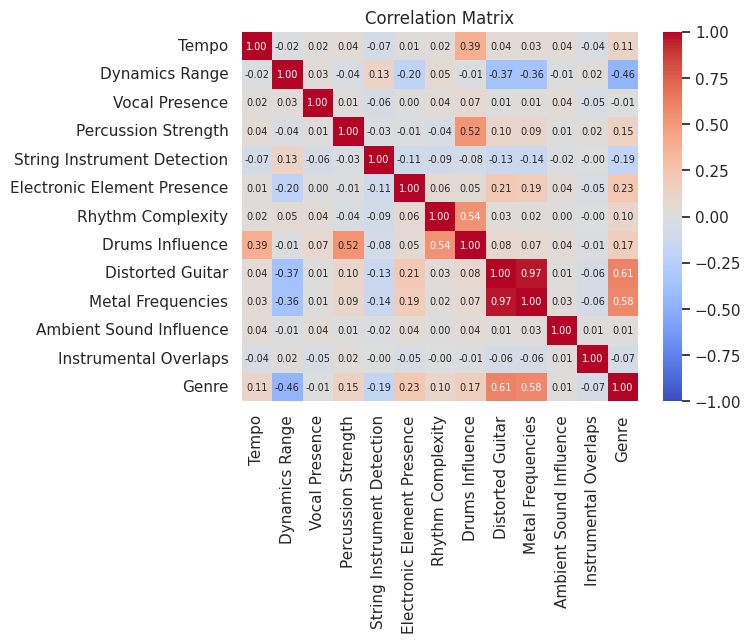

In [11]:
sns.heatmap(df_genre_nonull_enc.corr(), vmin = -1, vmax = 1, cmap = "coolwarm", annot = True, annot_kws = {"fontsize": 7}, fmt = ".2f")

plt.title("Correlation Matrix");

Notes:
- "Genre" appears to be influenced by various features.
- "Genre" shows high correlations with "Distorted Guitar" (0.61), "Metal Frequencies" (0.58), "Dynamics Range" (-0.46), and "Electronic Element Presence" (0.23).

## PCA for Dimensionality Reduction
- Capture at least 80% of the data's variance.
- Analyze the explained variance by the components.
- Decide on the optimal number of principal components based on the cumulative variance.

In [12]:
# Standardize features
std = StandardScaler()
X_std = std.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Get "explained variance" info
explained_variance = pca.explained_variance_ratio_

__PCA is sensitive to the variances of the features__. If the features are not standardized, those with larger variances will dominate the principal components, leading to a biased result. __Standardizing the data ensures that each feature contributes equally to the analysis__.

In PCA, __explained variance__ refers to __the amount of variance of the original data that is explained by each principal component__. Each principal component is a linear combination of the original variables, ordered so that the first principal component explains the largest possible variance in the data, the second component explains the second largest variance, and so on.

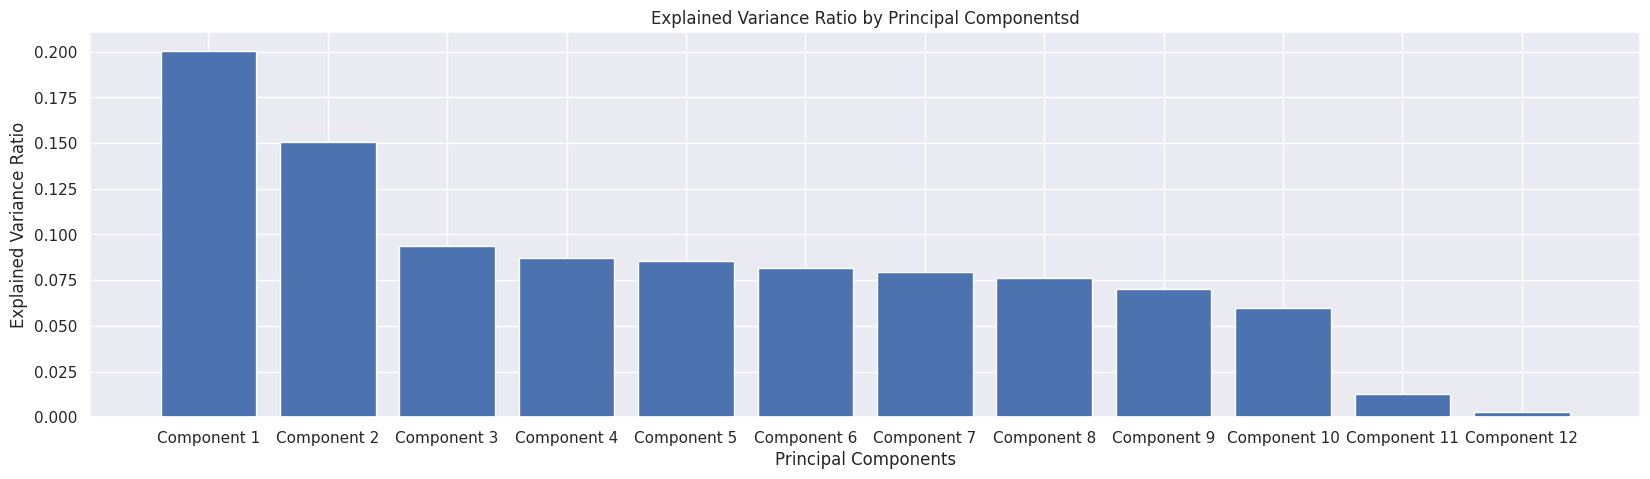

In [13]:
no_components = len(explained_variance)

components = []
for i in range(1, no_components + 1):
    components.append("Component " + str(i))

plt.figure(figsize = (20, 5))
    
plt.bar(components, explained_variance)
plt.title("Explained Variance Ratio by Principal Componentsd")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio");

Also, __cumulative explained variance__ can be used to determine __how much of the total variance in the dataset is explained by a certain number of principal components__. It helps in deciding how many principal components to retain for dimensionality reduction or feature extraction purposes.

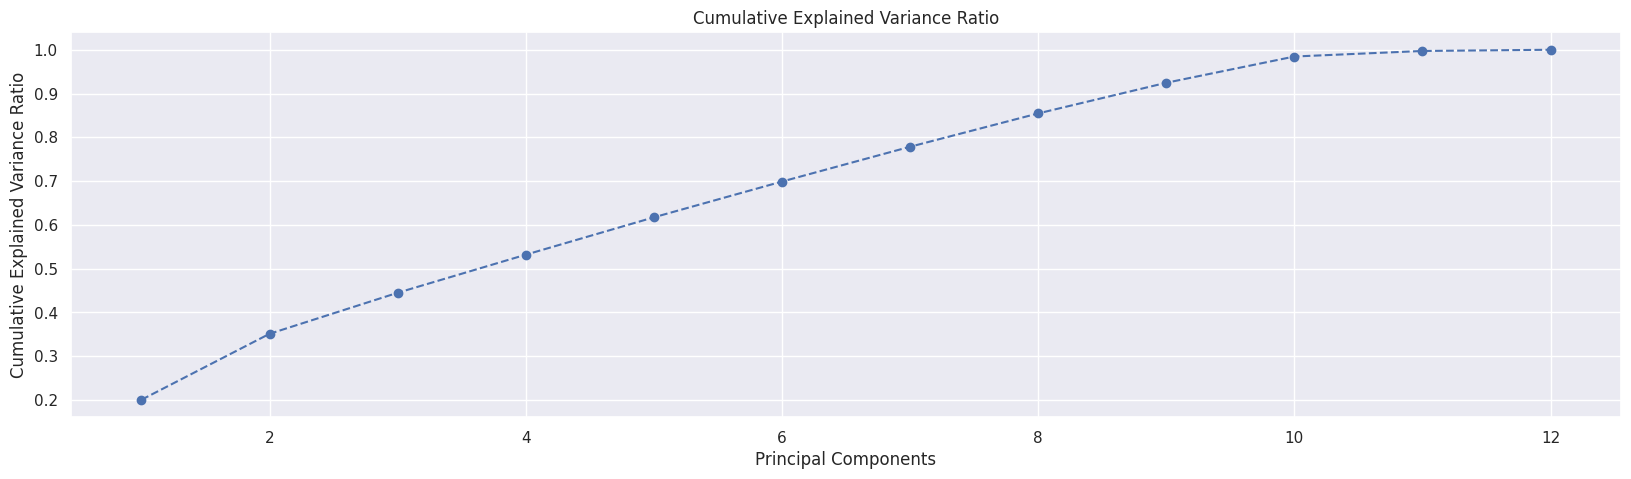

In [14]:
plt.figure(figsize = (20, 5))

plt.plot(range(1, no_components + 1), explained_variance.cumsum(), marker = "o", linestyle = "--")

plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio");

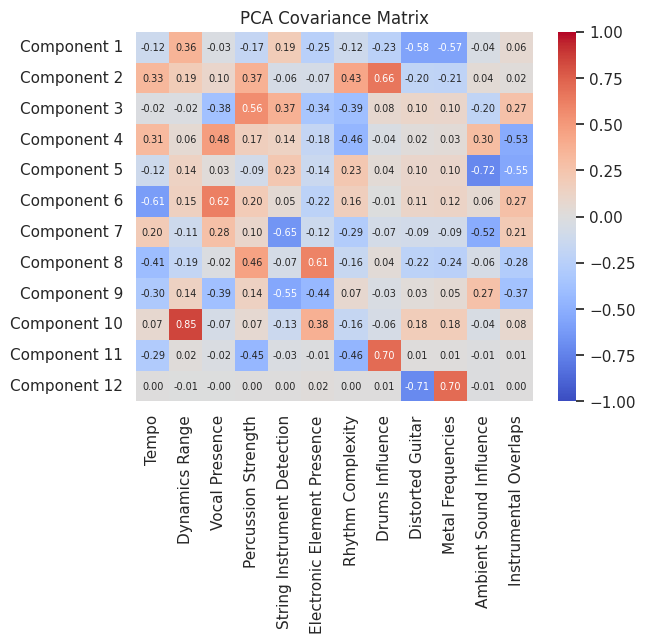

In [15]:
df_pca = pd.DataFrame(data = pca.components_, columns = X.columns.values, index = components)

sns.heatmap(df_pca, vmin = -1, vmax = 1, cmap = "coolwarm", annot = True, annot_kws = {"fontsize": 7}, fmt = ".2f")

plt.title("PCA Covariance Matrix");

Notes:
- The first two components account for about 35% of the total variance. The explained variance ratio by the next eight (components 3-10) is roughtly the same.  
- It seems that we need to retain 8 components to achieve 80% of the variance.
- Looking at the PCA Covariance Matrix, the 1st PC is has strong negative correlation to "Distorted Guitar" and "Metal Frequencies" as well as a positive correlation with "Dynamics Range." It seems that the 1st PC represents the characteristics of classical music as both "Distorted Guitar" and "Metal Frequencies" are not really applicable to classical music and classical music usually has wide dynamics range from very soft to very loud.
- The 2nd PC has stronger correlations with "Drums Influence", "Rhythm Complexity" followed by "Percussion Strength", and "Tempo." It seems that the 2nd PC represents the characteristics of Jazz music as drums are central of jazz and rhythm is also complex with syncopation and improvisaztion.

In [16]:
pca = PCA(n_components = 8)
X_pca = pca.fit_transform(X_std)

# you can also pass a cumulative variance ratio that you want to achieve (in our case 0.8) as an argument of PCA()
# pca = PCA(0.8)
# X_pca = pca.fit_transform(X_std)

## Evaluate Classification Efficacy - PCA-Transformed vs. Original

### PCA-Transformed

In [17]:
# Split PCA-transformed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_enc, test_size = 0.3, random_state = 42)

# Employ a Logistic Regression model
lr_pca = LogisticRegression(max_iter = 10000)
lr_pca.fit(X_train, y_train)

# Predict
y_pred = lr_pca.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names = le.classes_))

Accuracy: 0.5355805243445693

Classification Report:
               precision    recall  f1-score   support

   Classical       0.89      0.98      0.93        51
     Country       0.32      0.23      0.27        52
     Hip-hop       0.49      0.44      0.46        48
        Jazz       0.41      0.42      0.42        62
        Rock       0.51      0.63      0.56        54

    accuracy                           0.54       267
   macro avg       0.52      0.54      0.53       267
weighted avg       0.52      0.54      0.52       267



### Original

In [18]:
# Split PCA-transformed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y_enc, test_size = 0.3, random_state = 42)

# Employ a Logistic Regression model
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names = le.classes_))

Accuracy: 0.5280898876404494

Classification Report:
               precision    recall  f1-score   support

   Classical       0.86      0.98      0.92        51
     Country       0.33      0.25      0.28        52
     Hip-hop       0.45      0.46      0.45        48
        Jazz       0.44      0.39      0.41        62
        Rock       0.49      0.59      0.54        54

    accuracy                           0.53       267
   macro avg       0.51      0.53      0.52       267
weighted avg       0.51      0.53      0.52       267



Notes:
- The model using PCA-transformed features outperformed the model using original features.
- It's important to note that even with PCA transformation, the accuracy was only 53.6%, which is relatively low. However, the key takeaway is that PCA can sometimes improve model accuracy despite losing some data. We will utilize the PCA-transformed version for predicting new data.

## Genre Prediction

In [19]:
# Create a dataframe wherer "Genre" is all null
df_unknown = df_genre[df_genre['Genre'].isnull()]
X_unknown = df_unknown.drop(["Genre"], axis = 1)

# Standardize
X_unknown_std = std.transform(X_unknown)

# PCA-transform
X_unknown_pca = pca.transform(X_unknown_std)

In [20]:
# Predict
y_pred_unknown = lr_pca.predict(X_unknown_pca)

# Transform predictions into their original genre labels
df_unknown.loc[:, "Genre"] = le.inverse_transform(y_pred_unknown)

In [21]:
df_unknown

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
13,104.389822,65.826509,45.855410,55.655533,76.058845,55.625315,25.312585,59.202818,0.920308,0.000000,94.308889,27.441046,Classical
18,101.367152,47.843370,93.230347,67.101777,20.932163,50.772288,30.348312,62.950165,64.462755,68.971944,21.690071,94.717315,Country
22,85.130539,55.707108,81.149615,21.473425,14.959208,61.017283,64.000152,43.332846,70.455879,79.053598,20.420619,99.499498,Country
31,121.100952,71.769727,49.609529,82.539647,47.670106,119.460607,68.812707,83.727876,95.307620,95.779062,2.883916,19.230684,Rock
42,93.546825,44.563761,56.587554,99.546134,109.735122,30.128106,48.392807,81.888793,97.200948,100.000000,16.380240,55.483399,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,130.719110,65.990957,21.775950,91.817048,34.029452,105.525736,28.552899,99.587397,1.414556,0.000000,59.447447,74.901837,Hip-hop
992,117.892313,35.001524,76.506358,77.972570,80.765657,13.759213,59.985923,80.108786,93.831262,100.000000,15.851851,47.984445,Rock
993,104.315096,26.173723,3.334345,42.132602,38.434513,66.522798,62.051560,79.475348,61.390214,52.925363,50.383816,52.630256,Hip-hop
994,121.863373,50.872678,70.100162,106.212013,66.573813,89.927526,3.009635,79.634816,15.398297,31.235519,11.997421,57.281283,Hip-hop


## Summary

In this project, we applied Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, interpreted each principal component and explained variance, and successfully improved model accuracy over the original features. We used PCA for dimensionality reduction in this project, but it can also be used for feature selection and visualization purposes. 

Thank you for reading this kernel!